## ResNet50

In [1]:
import os
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from lightning import LightningModule, Trainer
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from lightning import seed_everything
from PIL import Image
from torchmetrics.functional import accuracy
from lightning.pytorch.callbacks.progress import TQDMProgressBar
import pandas as pd
import seaborn as sn
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
import glob
import timm
import timm.optim
import numpy as np
from timm.scheduler import CosineLRScheduler
torch.set_float32_matmul_precision('high')

In [2]:
# PCBData 데이터셋 클래스를 정의합니다.
class PCBData(Dataset):
    def fold_split(self, root_dir='pcb_test/TRUE', fold_current = 1, fold=5, test_ratio=0.1):
        dirs = sorted(glob.glob(root_dir+'/**'))
        train_files = []
        val_files = []
        test_files = []
        for d in dirs:
            files = sorted(glob.glob(d+'/**/*.bmp', recursive=True))
            files = list(np.random.permutation(files))
            n_files = len(files)
            prev_cnt = 0
            for i in range(fold):
                cnt = (n_files//fold) + (1 if i >= fold-n_files%fold else 0) 
                test_cnt = int(cnt*fold*test_ratio)
                if test_cnt == 0 and cnt > 0:
                    test_cnt = 1
                val_cnt = cnt - test_cnt
                if i != fold-fold_current-1:
                    train_files += files[prev_cnt:prev_cnt+cnt]
                else:
                    val_files += files[prev_cnt:prev_cnt+val_cnt]
                    test_files += files[prev_cnt+val_cnt:prev_cnt+cnt]
                prev_cnt += cnt
        return train_files, val_files, test_files
    
    def __init__(self, root_dir, transform=None, stage='train', fold=0):
        self.root_dir = root_dir
        self.transform = transform
        
        np.random.seed(42)
        ng_train_files, ng_val_files, ng_test_files = self.fold_split(root_dir+'/TRUE', fold_current=0)
        ok_train_files, ok_val_files, ok_test_files = self.fold_split(root_dir+'/FALSE', fold_current=0)
        train_files = [(file, 0) for file in ng_train_files] + [(file, 1) for file in ok_train_files]
        val_files = [(file, 0) for file in ng_val_files] + [(file, 1) for file in ok_val_files]
        test_files = [(file, 0) for file in ng_test_files] + [(file, 1) for file in ok_test_files]
        
        '''
        ng_files = sorted(glob.glob(os.path.join(root_dir, 'TRUE/**/*.bmp'), recursive=True))
        ok_files = sorted(glob.glob(os.path.join(root_dir, 'FALSE/**/*.bmp'), recursive=True))
        # NG와 OK 파일들에 대해 라벨 할당
        ng_files = [(file, 0) for file in ng_files]
        ok_files = [(file, 1) for file in ok_files]
        
        ng_files = np.random.permutation(ng_files)
        ok_files = np.random.permutation(ok_files)
        ng_files = [(s, int(i)) for s,i in ng_files]
        ok_files = [(s, int(i)) for s,i in ok_files]

        def fold_list(files, fold=0):
            fold_no = 5
            fold_split = len(files)//fold_no*fold
            return files[fold_split:]+files[:fold_split]

        ng_files, ok_files = fold_list(ng_files, fold), fold_list(ok_files, fold)
        
        # NG와 OK 각각을 8:1:1로 나누기 위한 인덱스 계산
        def split_indices(files):
            n = len(files)
            return int(n*0.8), int(n*0.9)

        ng_split, ok_split = split_indices(ng_files), split_indices(ok_files)
        
        # 데이터셋 나누기
        train_files = ng_files[:ng_split[0]] + ok_files[:ok_split[0]]
        val_files = ng_files[ng_split[0]:ng_split[1]] + ok_files[ok_split[0]:ok_split[1]]
        test_files = ng_files[ng_split[1]:] + ok_files[ok_split[1]:]
        '''

        if stage == 'train':
            self.files = train_files
        elif stage == 'val':
            self.files = val_files
        else:
            self.files = test_files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path, label = self.files[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def image_file(self, idx):
        return self.files[idx]

# LitResnet 클래스를 정의
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.save_hyperparameters()
        # ResNet18 대신 ResNet50 사용
        #self.model = torchvision.models.resnet50(pretrained=False, num_classes=2)
        #self.lr = lr
        #self.model = timm.create_model('resnet50d', pretrained=True, num_classes=2, drop_path_rate=0.05)
        self.model = timm.create_model('resnet50d', pretrained=True, num_classes=2, drop_rate=0.3)
        #self.model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        #self.model.fc = torch.nn.Linear(in_features=2048, out_features=2)

    def forward(self, x):
        return F.log_softmax(self.model(x), dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("lr", self.myoptimizer.param_groups[0]['lr'], prog_bar=True)
        return loss

    def configure_optimizers(self):
        #print('lr =', self.hparams.lr)
        #optimizer = torch.optim.SGD(
        #optimizer = torch.optim.Adam(
        #    self.parameters(),
        #    lr=self.hparams.lr,
        #    #momentum=0.9,
        #    #weight_decay=5e-4,
        #)
        optimizer = timm.optim.create_optimizer_v2(
            self, opt="lookahead_AdamW", lr=self.hparams.lr, weight_decay=0.01
        )
        self.myoptimizer = optimizer
        
        #steps_per_epoch = 45000 // BATCH_SIZE
        #steps_per_epoch = 10206 // BATCH_SIZE + 1
        #steps_per_epoch = 3000 // BATCH_SIZE

        scheduler_dict = {
            #"scheduler": OneCycleLR(
            #    optimizer,
            #    0.002,
            #    epochs=self.trainer.max_epochs,
            #    steps_per_epoch=steps_per_epoch,
            #    #steps_per_epoch=1, ## LR
            #),
            "scheduler": CosineAnnealingLR(
                optimizer,
                T_max=self.trainer.max_epochs,
                eta_min=1e-6
            ),
            "interval": "epoch",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}
        #return {"optimizer": optimizer}

    # Learning rate warm-up
    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_closure):
        # update params
        optimizer.step(closure=optimizer_closure)
    
        # manually warm up lr without a scheduler
        warm_up_t = 3
        lr_warmup_min = 1e-4
        step = self.trainer.current_epoch
        if step < warm_up_t:
            lr_scale = min(1.0, float(step + 1) / float(warm_up_t))
            for pg in optimizer.param_groups:
                pg["lr"] = max(lr_warmup_min, lr_scale * self.hparams.lr)

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=2)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, sync_dist=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, sync_dist=True)
    
    def evaluate_debug(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=2)
        #print('loss =', loss)
        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, sync_dist=True)
            self.log(f"{stage}_acc", acc, prog_bar=True, sync_dist=True)
        #print(f"{stage}_loss", loss.cpu().numpy(), f"{stage}_acc", acc.cpu().numpy())

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")
        
    def validation_step(self, batch, batch_idx):
        self.evaluate_debug(batch, "val")
        
    def setup(self, stage=None):
        # 데이터 변환 정의
        '''
        transform = transforms.Compose([
            #transforms.Resize((32, 32)),
            transforms.ToTensor(),
            #pcb_normalization(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),] )
        '''
        train_transforms = torchvision.transforms.Compose(
            [
                #torchvision.transforms.Resize((224,224)),
                #torchvision.transforms.RandomCrop(32, padding=4), #Augmentation 포함
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomVerticalFlip(),
                torchvision.transforms.RandomApply([transforms.RandomRotation(90)], p=0.5),
                torchvision.transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        val_transforms = torchvision.transforms.Compose(
            [
                #torchvision.transforms.Resize((224,224)),
                torchvision.transforms.ToTensor(),
                #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
    
        # 데이터셋 로드
        self.train_dataset = PCBData(root_dir='pcb_test', transform=train_transforms, stage='train')
        self.val_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='val')
        self.test_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='test')
        
        ##self.train_dataset, self.val_dataset, self.test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])
        #print(train_size, val_size, test_size)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)

# 설정
seed_everything(7, workers=True)
#BATCH_SIZE = 256 if torch.cuda.is_available() else 64
BATCH_SIZE = 32 if torch.cuda.is_available() else 64
#BATCH_SIZE = 32 if torch.cuda.is_available() else 64

#NUM_WORKERS = int(os.cpu_count() / 2)
NUM_WORKERS = 4

FOLD = 0

model = LitResnet(lr=0.0002)

checkpoint_callback = ModelCheckpoint(monitor='val_acc', dirpath='./ckpt', mode='max', verbose=True)

# ResNet 모델에 대한 Trainer 설정
trainer = Trainer(
    max_epochs=20,
    #max_epochs=4,
    accelerator="auto",
    devices=4 if torch.cuda.is_available() else None,
    logger=CSVLogger(save_dir="./"),  # ResNet 모델 로그를 저장할 폴더 지정
    #callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=1), checkpoint_callback],
    callbacks=[checkpoint_callback],
    #callbacks=[TQDMProgressBar()],
    #deterministic=True,
    log_every_n_steps=10,
)
# 데이터셋 준비
#model.setup()
# 훈련을 시작합니다.
log_dir = trainer.logger.log_dir
trainer.fit(model)
# 테스트를 진행합니다.
#trainer.test(model)

Seed set to 7
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
[rank: 0] Seed set to 7
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
[rank: 1] Seed set to 7
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
[rank: 2] Seed set to 7
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
[rank: 3] Seed set to 7
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

/home/kotech/venv-pl/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/kotech/workspace/webstudy/deep/lightning/ckpt exists and is not empty.
LOCAL_RANK: 3 - CUDA_VISIBLE_

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Epoch 0, global step 59: 'val_acc' reached 0.73820 (best 0.73820), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=0-step=59.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 1, global step 118: 'val_acc' reached 0.79936 (best 0.79936), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=1-step=118.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 2, global step 177: 'val_acc' reached 0.87983 (best 0.87983), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=2-step=177.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 3, global step 236: 'val_acc' reached 0.92382 (best 0.92382), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=3-step=236-v5.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 4, global step 295: 'val_acc' reached 0.93348 (best 0.93348), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=4-step=295.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 5, global step 354: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 6, global step 413: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 7, global step 472: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 8, global step 531: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 9, global step 590: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 10, global step 649: 'val_acc' reached 0.93777 (best 0.93777), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=10-step=649-v2.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 11, global step 708: 'val_acc' reached 0.93884 (best 0.93884), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=11-step=708.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 12, global step 767: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 13, global step 826: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 14, global step 885: 'val_acc' reached 0.93991 (best 0.93991), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=14-step=885.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 15, global step 944: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 16, global step 1003: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 17, global step 1062: 'val_acc' was not in top 1


Validation: |                                                                                                 …

Epoch 18, global step 1121: 'val_acc' reached 0.94528 (best 0.94528), saving model to '/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=18-step=1121-v1.ckpt' as top 1


Validation: |                                                                                                 …

Epoch 19, global step 1180: 'val_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=20` reached.


In [3]:
model

LitResnet(
  (model): ResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [4]:
trainer.logger.log_dir, log_dir

('./lightning_logs/version_153', './lightning_logs/version_153')

In [5]:
ckpt_path =checkpoint_callback.best_model_path 
ckpt_path

'/home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=18-step=1121-v1.ckpt'

,lr,train_loss,val_acc,val_loss
epoch,,,,
0,0.0001,0.612465,NaN,NaN
0,0.0001,0.621879,NaN,NaN
0,0.0001,0.570280,NaN,NaN
0,0.0001,0.499830,NaN,NaN
0,0.0001,0.486499,NaN,NaN


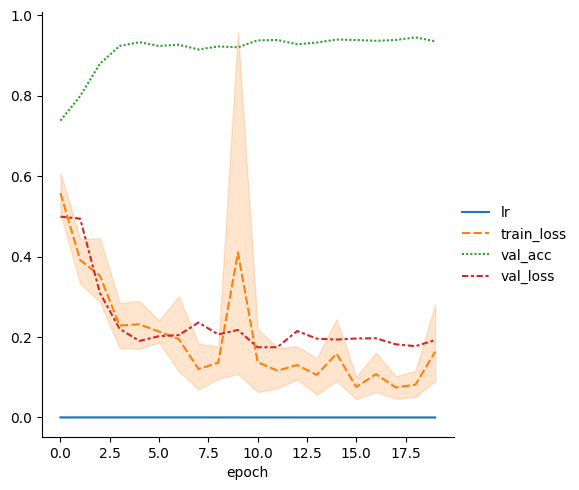

In [6]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

,lr,train_loss,val_acc,val_loss
epoch,,,,
0,0.0001,0.612465,NaN,NaN
0,0.0001,0.621879,NaN,NaN
0,0.0001,0.570280,NaN,NaN
0,0.0001,0.499830,NaN,NaN
0,0.0001,0.486499,NaN,NaN


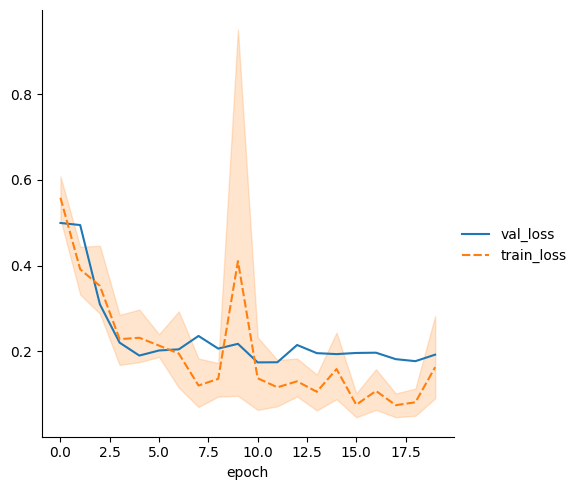

In [7]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics[['val_loss', 'train_loss']], kind="line")

/tmp/ipykernel_2739499/956773166.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  metrics['lr'] = metrics['lr'].fillna(method='ffill')


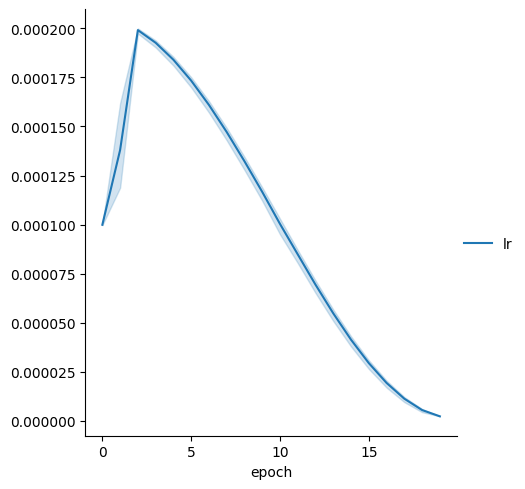

In [8]:
import pandas as pd
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
metrics = metrics[::-1]
#metrics['lr-Adam'] = metrics['lr-Adam'].fillna(method='ffill')
metrics['lr'] = metrics['lr'].fillna(method='ffill')
metrics = metrics[::-1]
#print(metrics[['lr-Adam']].head(10))
#sn.relplot(data=metrics[['lr-Adam']], kind="line") ## Learning Rate Matrix
sn.relplot(data=metrics[['lr']], kind="line") ## Learning Rate Matrix

In [9]:
trainer = Trainer(
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kotech/venv-pl/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [10]:
trainer.test(model, ckpt_path=ckpt_path)

Restoring states from the checkpoint path at /home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=18-step=1121-v1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /home/kotech/workspace/webstudy/deep/lightning/ckpt/epoch=18-step=1121-v1.ckpt


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9517167210578918
        test_loss           0.1451072096824646
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1451072096824646, 'test_acc': 0.9517167210578918}]

In [11]:
trainer.validate(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Validation: |                                                                                                 …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9452789425849915
        val_loss            0.1772404909133911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.1772404909133911, 'val_acc': 0.9452789425849915}]

In [14]:
train_files = []
len(model.train_dataset)+ len(model.val_dataset)+ len(model.test_dataset)

9289

In [11]:
def eval_dataset():

    val_transforms = torchvision.transforms.Compose(
        [
            #torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    #full_eval_dataset = PCBData(root_dir='PCB_data', transform=val_transforms)
    train_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='train')
    val_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='val')
    test_dataset = PCBData(root_dir='pcb_test', transform=val_transforms, stage='test')

    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)

    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE//4, shuffle=False, num_workers=NUM_WORKERS)
    

    return train_dataloader, val_dataloader, test_dataloader
     


In [12]:
eval_train_dataloader, eval_val_dataloader, eval_test_dataloader = eval_dataset()

In [13]:
trainer.test(model, dataloaders=eval_train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9777957797050476
        test_loss          0.054842881858348846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.054842881858348846, 'test_acc': 0.9777957797050476}]

In [14]:
trainer.test(model, dataloaders=eval_val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9515607953071594
        test_loss           0.17188529670238495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.17188529670238495, 'test_acc': 0.9515607953071594}]

In [15]:
trainer.test(model, dataloaders=eval_test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9364908337593079
        test_loss           0.2340455949306488
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.2340455949306488, 'test_acc': 0.9364908337593079}]